## Introduction

In federated learning, data is distributed across multiple clients, often in a way that does not follow the typical assumptions of centralized machine learning. A key characteristic that influences the performance of federated systems is whether the data across clients is **IID** (Independent and Identically Distributed) or **non-IID**.

- **IID (Independent and Identically Distributed):** Each client holds data that is a random sample from the overall distribution. This mimics the typical scenario in centralized training where data is uniformly shuffled and split.
  
- **Non-IID:** Data is distributed in a skewed or imbalanced way, such that each client may only have access to a limited subset of classes or a biased distribution. This is common in real-world scenarios where users generate data with unique patterns (e.g., different handwriting styles, personalized preferences).

This notebook demonstrates how different data partitioning strategies affect the class distribution across clients. We explore three common partitioning techniques:
- IID random split
- Dirichlet distribution-based partitioning
- Sort-and-partition (label-limited) allocation

By visualizing the resulting distributions, we gain intuition into how data heterogeneity impacts federated learning.


## Setup and Dataset Loading

We begin by importing the necessary libraries and loading the CIFAR-10 dataset.

We also define a utility function to set random seeds for reproducibility, ensuring consistent partitioning results across runs.


In [1]:
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constants
TOTAL_CLIENTS = 10
PARTITION_SEED = 42

# Set the seed for reproducibility
def set_seed(seed=PARTITION_SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# Load CIFAR-10
def load_cifar10():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    return trainset, testset

# Load training data
trainset, _ = load_cifar10()


100%|██████████| 170498071/170498071 [00:17<00:00, 9963018.52it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Partitioning Strategies

To simulate different federated learning scenarios, we partition the CIFAR-10 training dataset among multiple clients using three distribution strategies:

- **IID (Independent and Identically Distributed):** Data is randomly shuffled and evenly split across clients. Each client sees a balanced and representative subset of all classes.

- **Dirichlet Distribution:** Data is distributed based on a Dirichlet distribution, allowing for controlled statistical heterogeneity. Lower alpha values lead to more skewed (non-IID) distributions, where clients specialize in fewer classes.

- **Sort-and-Partition (Label-Limited):** Clients are manually assigned a small number of unique class labels (e.g., 2 out of 10), and only receive samples from those classes. This simulates extreme non-IID cases often encountered in user-personalized data.

Each method results in a different class distribution across clients, which we will visualize in the next section.


In [2]:
# Partitioning function
def partition_data(
    dataset,
    distribution_type="iid",
    num_clients=TOTAL_CLIENTS,
    seed=PARTITION_SEED,
    dirichlet_alpha=0.5,
    labels_per_client=2,
):
    set_seed(seed)
    labels = np.array(dataset.targets)
    indices = np.arange(len(dataset))
    client_indices = defaultdict(list)

    if distribution_type == "iid":
        np.random.shuffle(indices)
        split = np.array_split(indices, num_clients)
        for client_id, idx in enumerate(split):
            client_indices[client_id] = list(idx)

    elif distribution_type == "dirichlet":
        num_classes = 10
        class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
        for c in range(num_classes):
            np.random.shuffle(class_indices[c])
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients, num_classes)
        for cls_idx, cls_proportions in enumerate(proportions):
            cls_data = class_indices[cls_idx]
            cls_data_split = (np.cumsum(cls_proportions) * len(cls_data)).astype(int)[:-1]
            split_data = np.split(cls_data, cls_data_split)
            for client_id, data in enumerate(split_data):
                client_indices[client_id] += list(data)

    elif distribution_type == "sort_and_partition":
        num_classes = 10
        targets = dataset.targets
        if isinstance(targets, list):
            targets = np.array(targets)
        if isinstance(targets, torch.Tensor):
            targets = targets.numpy()
        prng = np.random.default_rng(seed)

        times = [0 for _ in range(num_classes)]
        contains = []

        for i in range(num_clients):
            current = [i % num_classes]
            times[i % num_classes] += 1
            j = 1
            while j < labels_per_client:
                index = prng.choice(num_classes, 1)[0]
                if index not in current:
                    current.append(index)
                    times[index] += 1
                    j += 1
            contains.append(current)

        idx_clients = [[] for _ in range(num_clients)]
        for class_id in range(num_classes):
            idx_class = np.where(targets == class_id)[0]
            prng.shuffle(idx_class)
            splits = np.array_split(idx_class, times[class_id])
            id_split = 0
            for client_id in range(num_clients):
                if class_id in contains[client_id]:
                    idx_clients[client_id].extend(splits[id_split].tolist())
                    id_split += 1

        return {client_id: Subset(dataset, idxs) for client_id, idxs in enumerate(idx_clients)}

    else:
        raise ValueError("Unsupported distribution type. Choose from 'iid', 'dirichlet', or 'sort_and_partition'.")

    return {client_id: Subset(dataset, indices) for client_id, indices in client_indices.items()}


## Visualizing Class Distribution Per Client

To better understand how each partitioning strategy distributes data, we visualize the class distribution per client using bar plots.

Each subplot represents one client, with bars showing the number of samples for each CIFAR-10 class. This allows us to clearly see the differences in how balanced or skewed the data is across clients:

- In **IID**, each client should have a fairly even number of samples from all 10 classes.
- In **Dirichlet**, the distribution becomes more uneven depending on the alpha parameter. Lower alpha values increase skew.
- In **Sort-and-Partition**, each client is explicitly limited to a small number of labels, resulting in extreme non-IID behavior.

These visualizations help illustrate the impact of data heterogeneity in federated learning scenarios.


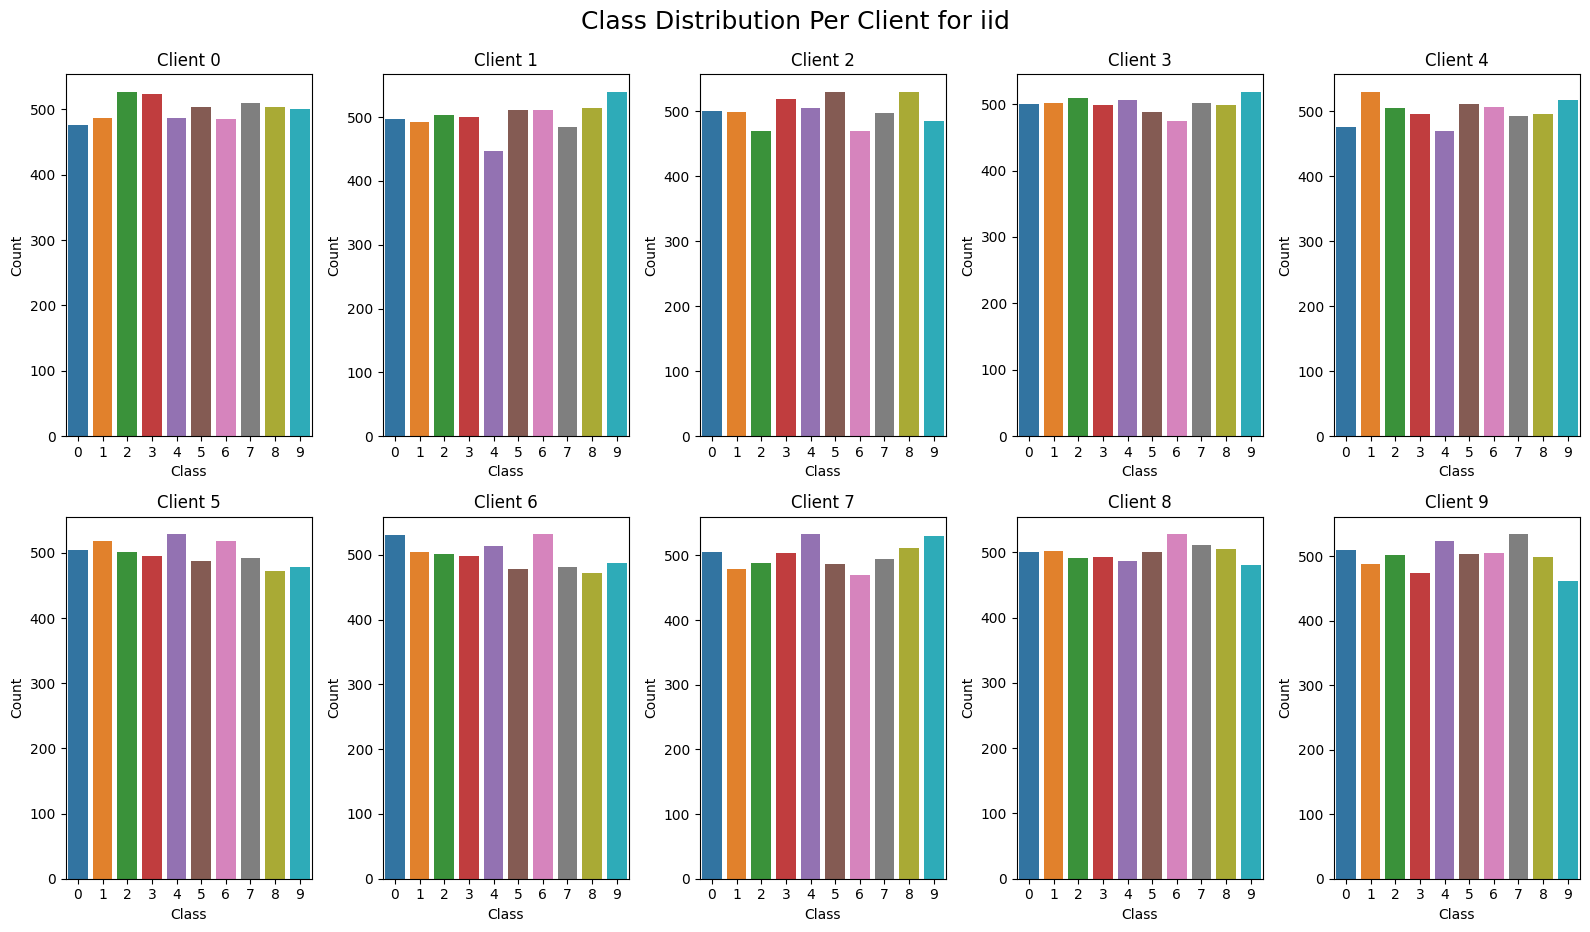

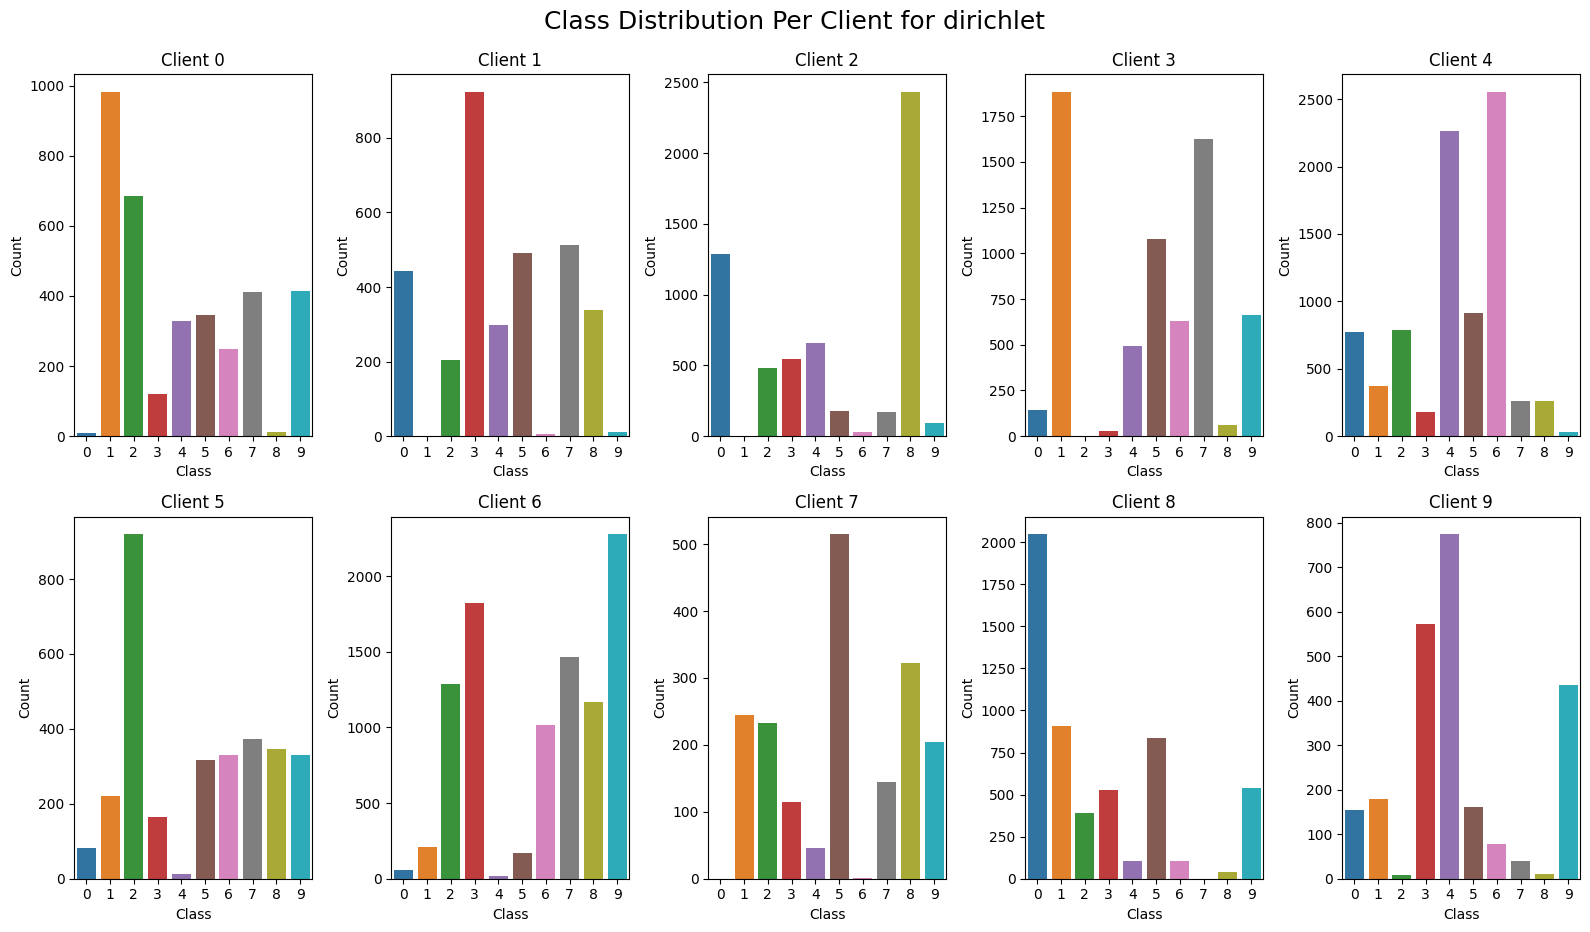

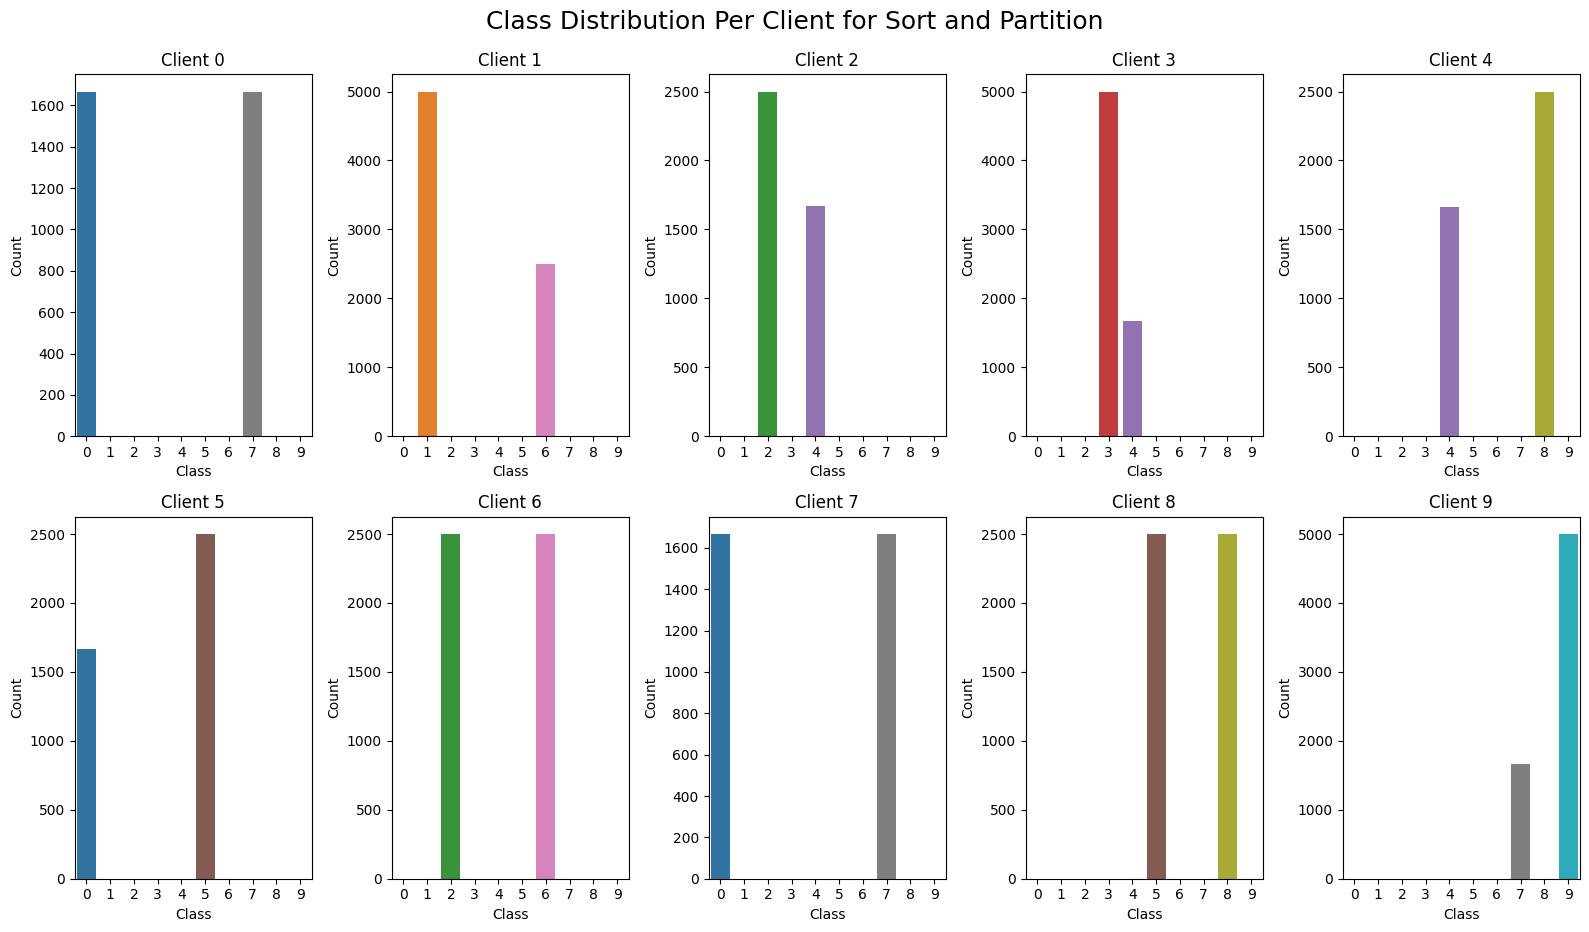

In [4]:
def plot_client_class_distribution(client_data, num_clients=TOTAL_CLIENTS, title="Class Distribution"):
    class_labels = list(range(10))
    palette = sns.color_palette("tab10", 10)

    plt.figure(figsize=(16, 9))
    for client_id in range(num_clients):
        dataset = client_data.get(client_id, None)

        if dataset is None or len(dataset) == 0:
            counts = [0] * 10
        else:
            labels = np.array(dataset.dataset.targets)[dataset.indices]
            counts = np.bincount(labels, minlength=10)

        df = pd.DataFrame({
            "class": class_labels,
            "count": counts,
            "class_str": [str(c) for c in class_labels]
        })

        plt.subplot(2, (num_clients + 1) // 2, client_id + 1)
        sns.barplot(data=df, x="class", y="count", hue="class_str", palette=palette, dodge=False, legend=False)
        plt.title(f"Client {client_id}")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.xticks(ticks=class_labels, labels=[str(i) for i in class_labels])
        plt.tight_layout()

    plt.suptitle(f"Class Distribution Per Client for {title}", fontsize=18, y=1.03)
    plt.show()


# Apply and visualize each distribution type
iid_data = partition_data(trainset, distribution_type="iid")
plot_client_class_distribution(iid_data, title = "iid")

dirichlet_data = partition_data(trainset, distribution_type="dirichlet", dirichlet_alpha=0.5)
plot_client_class_distribution(dirichlet_data, title = "dirichlet")

sorted_data = partition_data(trainset, distribution_type="sort_and_partition", labels_per_client=2)
plot_client_class_distribution(sorted_data, title = "Sort and Partition")


## Using Flower Libraries for Data Distributions

Flower provides the `flwr_datasets` library, which includes convenient partitioners for simulating data distribution across clients. These partitioners are compatible with popular datasets like CIFAR-10 and offer a standardized approach for building federated datasets.

In this section, we replicate the same three distribution types using Flower's partitioners:

- **IidPartitioner**: Evenly shuffles and splits data across clients.
- **DirichletPartitioner**: Applies a Dirichlet distribution to control data skew across clients. Smaller alpha values create stronger non-IID splits.
- **LabelPartitioner**: Ensures each client only receives data from a subset of classes, similar to the sort-and-partition approach.

These partitioners produce dictionaries mapping client IDs to their corresponding `Subset` objects, making them easy to use for simulation and analysis.


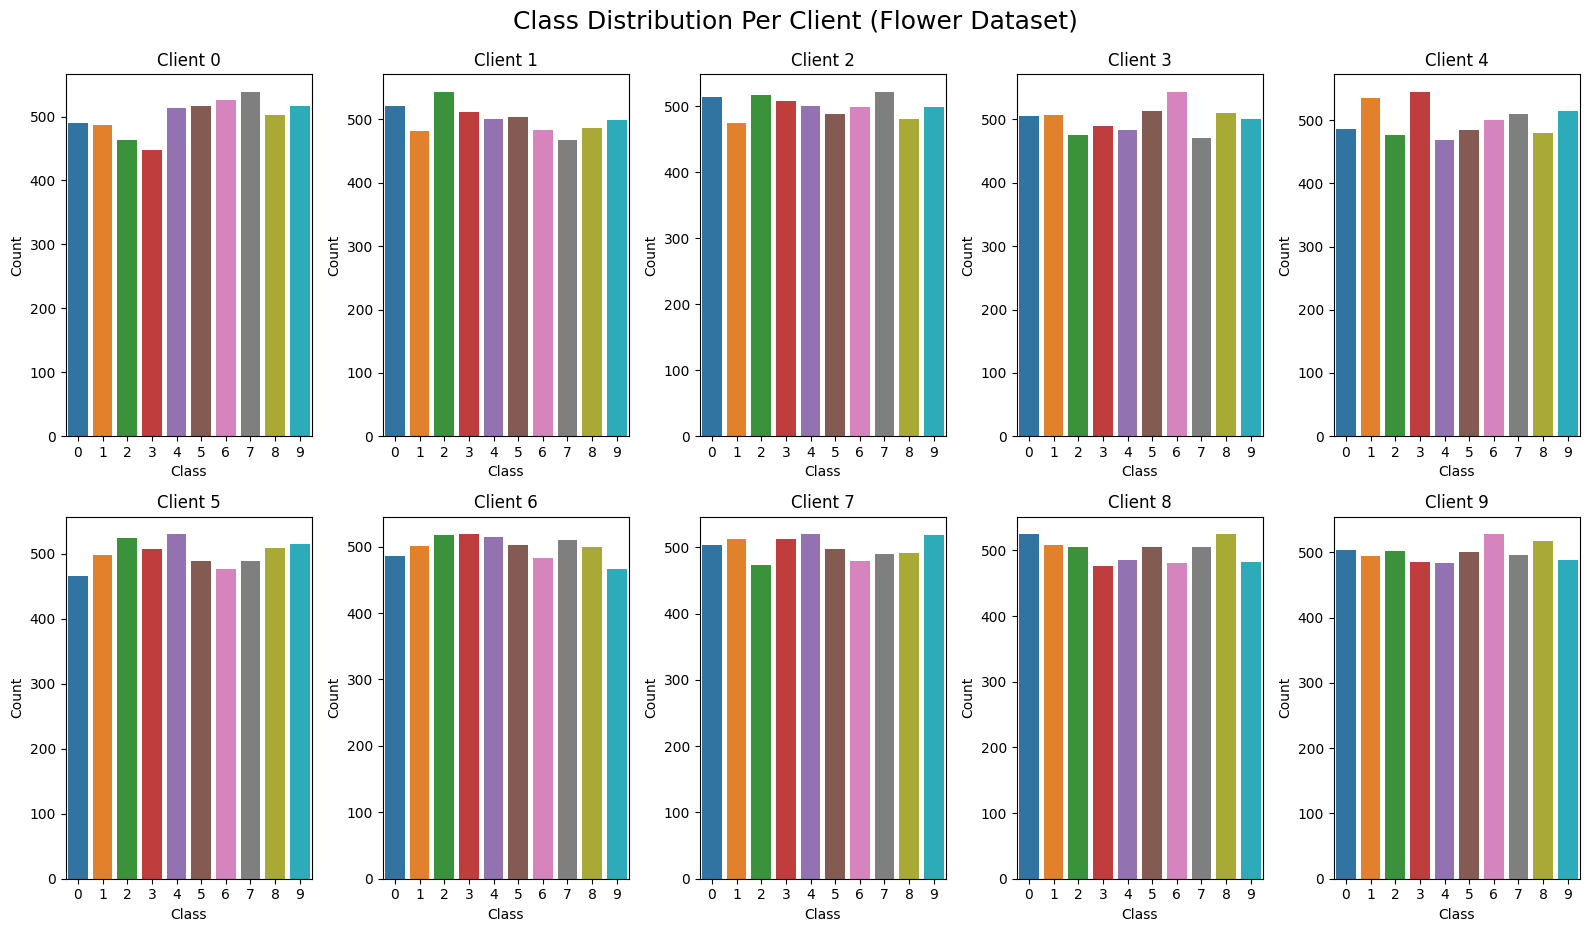

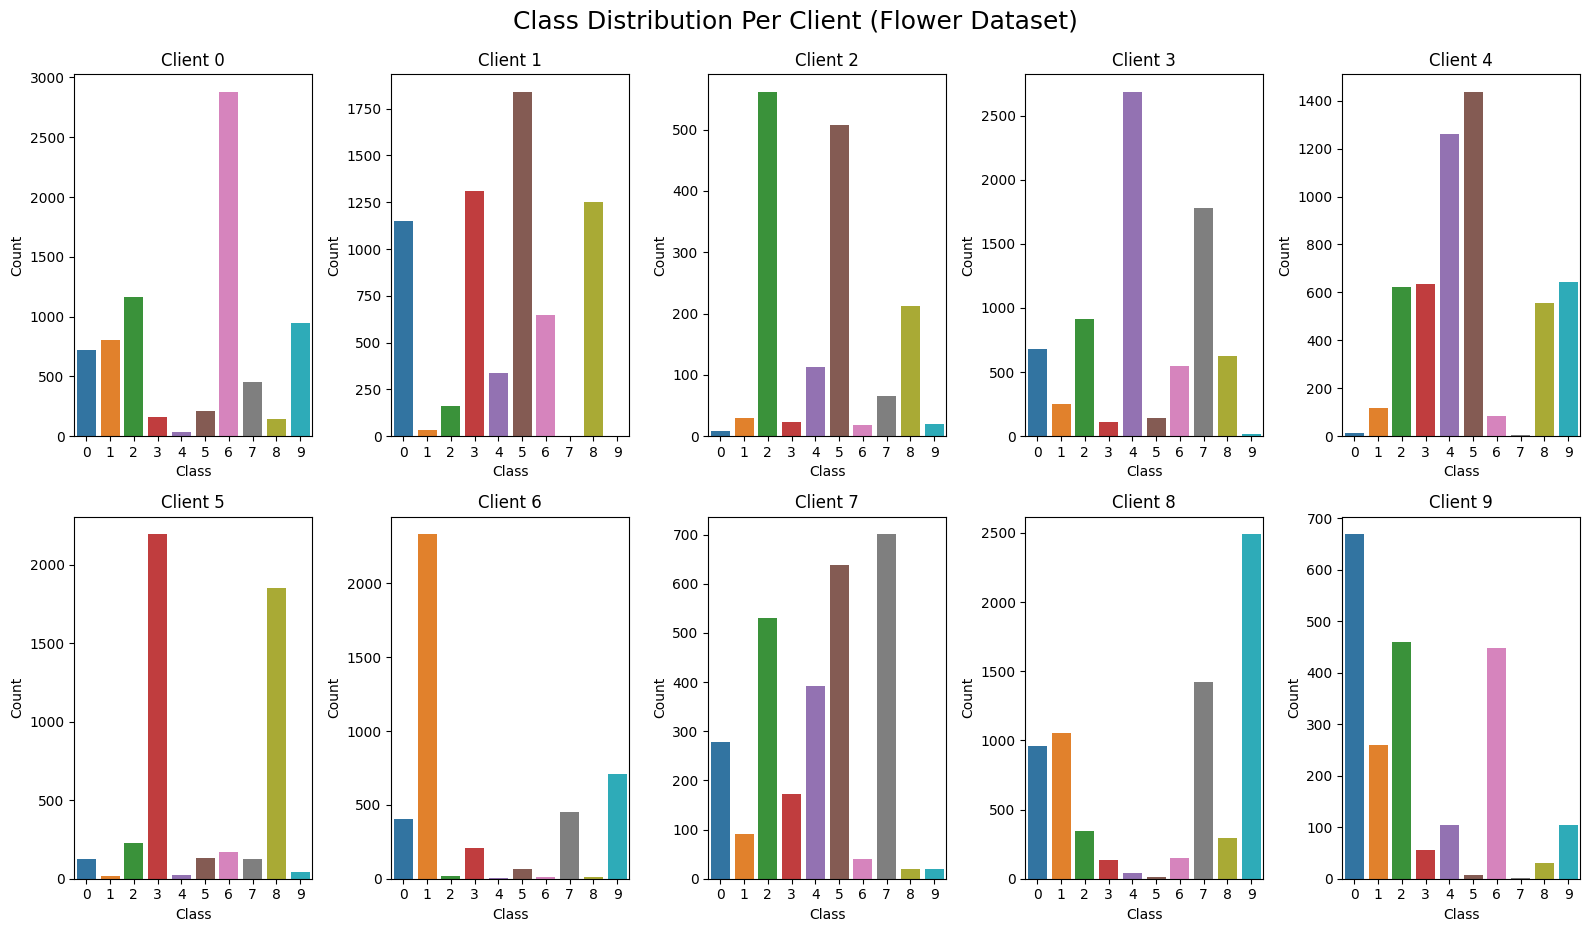

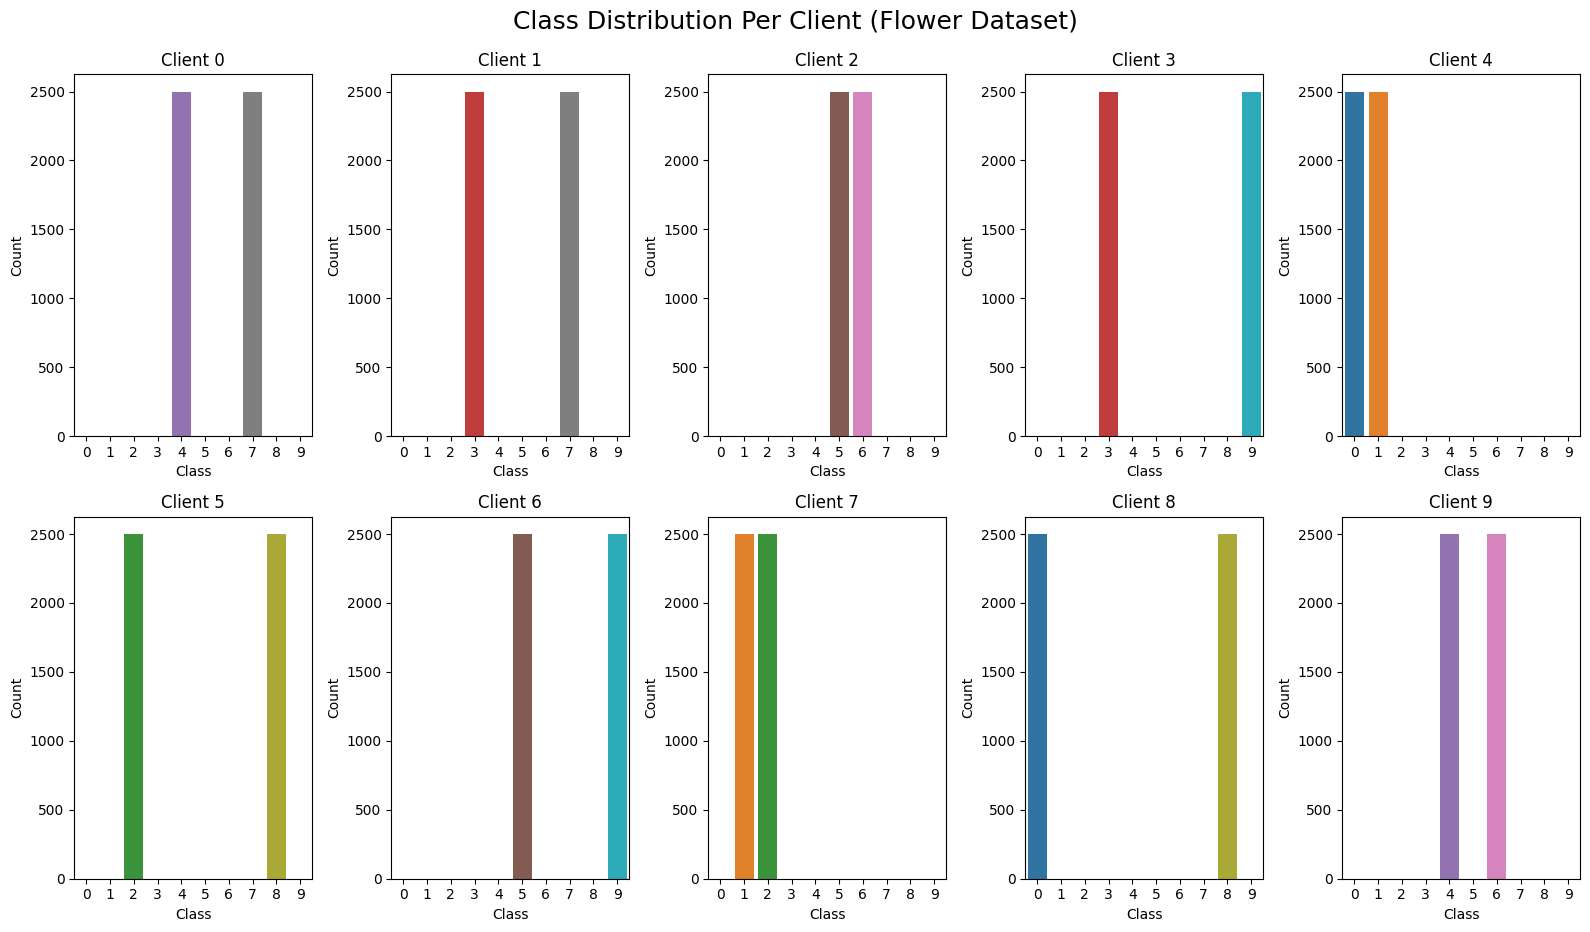

In [17]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, ShardPartitioner

# Constants
TOTAL_CLIENTS = 10

# Helper function to load all client partitions
def load_all_partitions(fds: FederatedDataset, num_clients: int):
    return {
        cid: fds.load_partition(partition_id=cid)
        for cid in range(num_clients)
    }
# Function to plot class distribution for Flower dataset
def plot_flower_dataset_distribution(client_data: dict, num_clients: int = TOTAL_CLIENTS):
    class_labels = list(range(10))
    palette = sns.color_palette("tab10", 10)

    plt.figure(figsize=(16, 9))
    for client_id in range(num_clients):
        dataset = client_data.get(client_id, None)

        if dataset is None or len(dataset) == 0:
            counts = [0] * 10
        else:
            labels = dataset["label"]
            counts = np.bincount(labels, minlength=10)

        df = pd.DataFrame({
            "class": class_labels,
            "count": counts,
            "class_str": [str(c) for c in class_labels]
        })

        plt.subplot(2, (num_clients + 1) // 2, client_id + 1)
        sns.barplot(data=df, x="class", y="count", hue="class_str", palette=palette, dodge=False, legend=False)
        plt.title(f"Client {client_id}")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.xticks(ticks=class_labels, labels=[str(i) for i in class_labels])
        plt.tight_layout()

    plt.suptitle("Class Distribution Per Client (Flower Dataset)", fontsize=18, y=1.03)
    plt.show()

# IID partitioning
iid_partitioner = IidPartitioner(num_partitions=TOTAL_CLIENTS)
fds_iid = FederatedDataset(
    dataset="uoft-cs/cifar10",
    partitioners={"train": iid_partitioner},
)
iid_data = load_all_partitions(fds_iid, TOTAL_CLIENTS)
plot_flower_dataset_distribution(iid_data)

# Dirichlet partitioning
dirichlet_partitioner = DirichletPartitioner(
    num_partitions=TOTAL_CLIENTS,
    alpha=0.5,
    partition_by="label",
)
fds_dirichlet = FederatedDataset(
    dataset="uoft-cs/cifar10",
    partitioners={"train": dirichlet_partitioner},
)
dirichlet_data = load_all_partitions(fds_dirichlet, TOTAL_CLIENTS)
plot_flower_dataset_distribution(dirichlet_data)

# Shard (label-limited) partitioning
shard_partitioner = ShardPartitioner(
    num_partitions=TOTAL_CLIENTS,
    partition_by="label",
    num_shards_per_partition=2,
)
fds_shard = FederatedDataset(
    dataset="uoft-cs/cifar10",
    partitioners={"train": shard_partitioner},
)
shard_data = load_all_partitions(fds_shard, TOTAL_CLIENTS)
plot_flower_dataset_distribution(shard_data)
